Author: Justus Hübotter
Date: May 2023

# Introduction to Spiking Neural Networks

In this first notebook of a series I give a brief overview what spiking neurons are, and explain how we can make use of them in a machine learning context. In this notebook, we will delve into the fascinating world of spiking neural networks (SNNs) and explore their fundamental components. SNNs are biologically inspired computational models that simulate the behavior of the brain at the level of individual neurons and their interconnections, enabling us to better understand the principles underlying neural information processing.

## Review of Biological Neurons


In this first segment, we will briefly review some neuroscience and computational models of neuronal communication. This is of course no replacement for an in-depth historical or mathematical analysis. Instead, to illustrate these concepts, I will include various graphics showcasing from a collection of fantastic external sources.

### Anatomy of Neurons

Neurons are the building blocks of the nervous system and play a crucial role in information processing. They exhibit diverse shapes and structures, with intricate branching patterns that allow for the integration and transmission of electrical signals. There is a wide variety of neuron types that can be categorized by shape, location, and / or primary function. However, some working principles of information processing are shared across the vast majority of these, and it is this set of core principles that we are most interested in (for now). Let us start with a single neuron.

### Neuron Communication

can exhibit various response patterns, such as regular firing, bursting, or adapting, which further contribute to the complexity of neural computations.

### Neuron Dynamics


## A First Example

I use Python and Pytorch to implement these networks, but the principles are applicable to implementations in other languages or modules.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using device {device}')

using device cpu


### Activation Functions

Let's take a look at some basic activation functions used to model the response of single neurons or populations of neurons to some given input stimulus. First, we make a little helper function for visualization.

In [12]:
def plot_activation_function(function: callable, name: str) -> None:
    ''' Plots the activation function for a given function and name.
    Args:
        function: The activation function to plot.
        name: The name of the activation function.

    Returns:
        None    
    '''

    x = torch.linspace(-10, 10, 1000)
    y = function(x)
    plt.plot(x, y)
    plt.title(f'Activation function: {name}')
    plt.xlabel('Input')
    plt.ylabel('Response')
    plt.grid()
    plt.show()

The first function is a simple identity function. It is completely linear and not very useful.

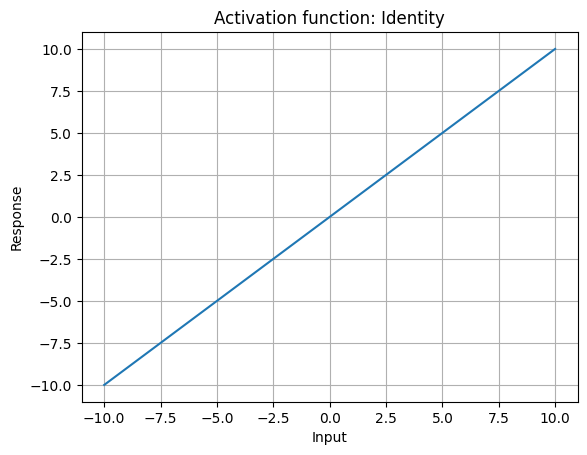

In [13]:
plot_activation_function(lambda x: x, 'Identity')

Next is a very popular function, the Rectified Linear Unit (ReLU). This function is piecewise linear with a potentially unbounded maximum positive response.

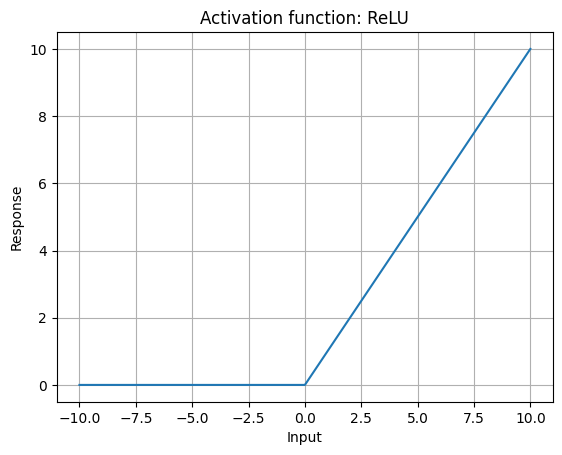

In [14]:
plot_activation_function(torch.relu, 'ReLU')

Biological neurons have a maximum firing rate. We can include this feature in our abstract model by using non-linear functions that are bounded, such as sigmoid or Tanh.

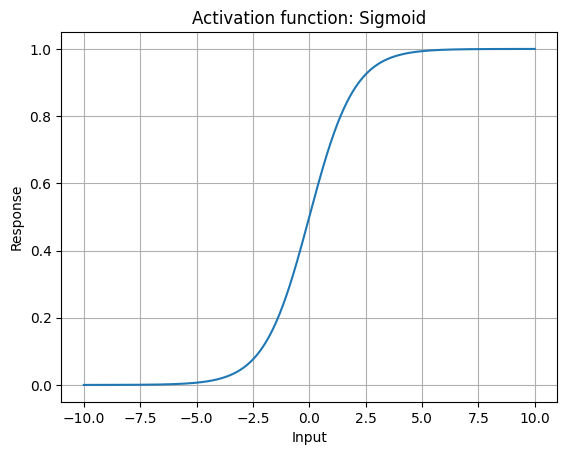

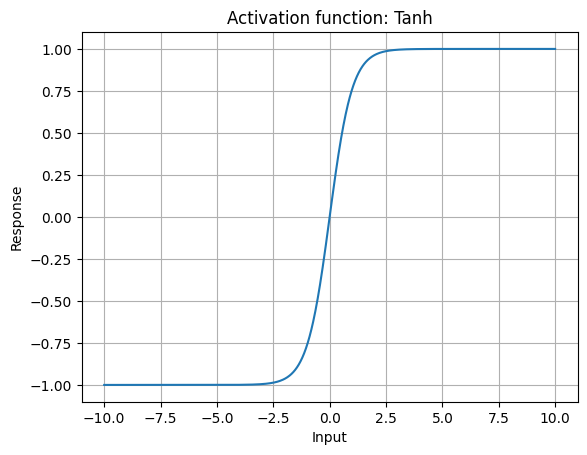

In [15]:
plot_activation_function(torch.sigmoid, 'Sigmoid')
plot_activation_function(torch.tanh, 'Tanh')

In spiking neural networks, we assume a binary response model in form of a step function. The resulting function is simple to compute and non-linear. However, the gradient of this function is 0 for any input, which is a problem if we want to use it in combination with gradient based learning methods. We will get back to this issue in more detail in a later notebook.

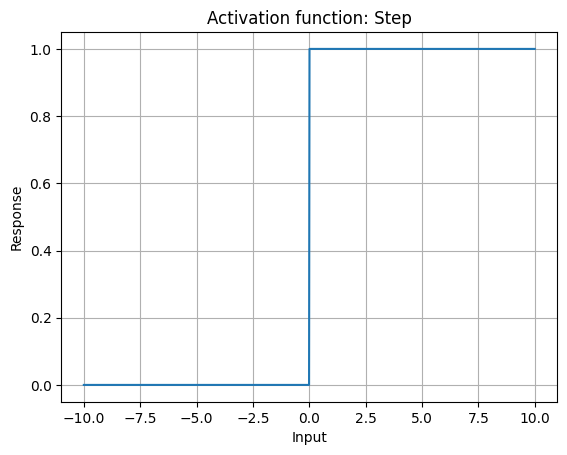

In [16]:
plot_activation_function(lambda x: x > 0, 'Step')

## Temporal Dynamics

Spiking neural networks use stateful neuron models, making them a subset of Recurrent neural networks. The input to the activation function is generally a hidden variable which itself evolves over time according to the temporal dynamics reviewed above. The complexity of these dynamics is generally arbitrary. This introduces
1. time as a key dimension in the information processing and
2. a number of equations that need to be solved repetitively
3. a number of parameters and variables that need to be (temporally) stored

In this example, I will focus on a simple case of temporal dynamics. Generally, we will try to follow Occam's razor and try to choose a model with minimal complexity that is appropriate for the research question at hand. Introducing extra steps in the equations to be solved and parameters to be stored is computationally expensive, so we try to evaluate the influence of every additional term in terms of it's utility. The simple model shown here will be made increasingly complex in the future in order to evaluate additions for exactly this utility in the context of different problems.

First, let's look at a single neuron with a double exponential filter. This neuron has a handful of parameters and hidden variables. We could try to choose their values so that the model might remain biologically interpretable. This makes sense when trying to directly model neural data. In our case it is sufficient to choose a resting potential of 0 (0% to spike) and a firing threshold at 1 (100% to spike). If needed, we can still map these values to biologically realistic ranges if needed.

In [17]:
def spike_function(x: torch.Tensor) -> torch.Tensor:
    """Computes the spike function for a given input.
    Args:
        x: The input tensor.

    Returns:
        The spike function.
    """
    return x > 0


class LIF(torch.nn.Module):
    """A spiking neuron based on the leaky integrate-and-fire model."""
    def __init__(
        self,
        tau_mem: float = 20e-3,
        tau_syn: float = 5e-3,
        threshold: float = 1.0,
        v_rest: float = 0.0,
        v_reset: float = 0.0,
        dt: float = 1e-3,
        spike_fn: callable = spike_function,
    ) -> None:
        super().__init__()
        self.tau_mem = tau_mem
        self.tau_syn = tau_syn
        self.threshold = threshold
        self.v_rest = v_rest
        self.v_reset = v_reset
        self.dt = torch.tensor(dt)
        self.spike_fn = spike_fn

        self.alpha = torch.exp(-self.dt / self.tau_syn)
        self.beta = torch.exp(-self.dt / self.tau_mem)

        self.reset()

    def reset(self) -> None:
        """Resets the membrane potential to the resting potential.
        Args:
            None

        Returns:
            None
        """
        self.i_syn = torch.tensor(0.0)
        self.v_mem = torch.tensor(self.v_rest)

    def forward(self, i_in: torch.Tensor) -> torch.Tensor:
        """Performs a forward pass through the LIF neuron.
        Args:
            i_syn: The synaptic input current.

        Returns:
            output activity of the LIF neuron.
        """

        # integrate synaptic current
        self.i_syn = self.alpha * self.i_syn + i_in
        # update membrane potential
        self.v_mem = self.beta * self.v_mem + (1 - self.beta) * self.i_syn
        # generate output spike
        spike = self.spike_fn(self.v_mem - self.threshold)
        # reset membrane potential
        self.v_mem = torch.where(spike, self.v_reset, self.v_mem)

        return spike

Do all this further up together with the math! 

TALK ABOUT EULER DISCRETIZATION 

TALK ABOUT ARBITRARY ORDER OF STEPS IN FORWARD FUNCTION.
This is done differently in different libraries for some reason.

TALK ABOUT DIFFERENT RESET MECHANISMS
- setting to v_rest via multiplication
- subtracting threshold

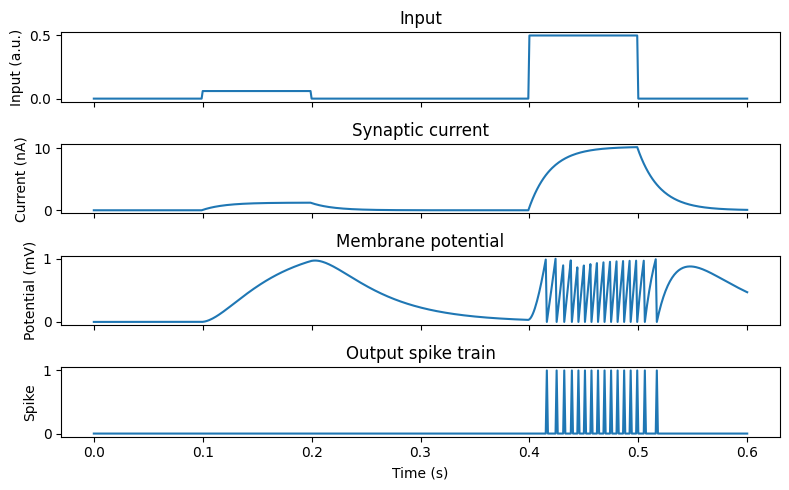

In [45]:
# some hyperparameters
T = 0.6 # total time to simulate (s)
dt = 1e-3 # simulation time step (s)
time = torch.arange(0, T+dt, dt) # time array

# LIF parameters
v_rest = 0.0 # resting potential (mV)
v_reset = 0.0 # reset potential (mV)
tau_mem = 50e-3 # membrane time constant (s)
tau_syn = 20e-3 # synaptic time constant (s)
threshold = 1.0 # spike threshold (V)

# create input spike train
input = torch.zeros(time.shape)
input[100:200] = 0.06
input[400:500] = 0.5

# create LIF neuron
lif = LIF(
    tau_mem=tau_mem,
    tau_syn=tau_syn,
    threshold=threshold,
    v_rest=v_rest,
    v_reset=v_reset,
    dt=dt,
)

# simulate LIF neuron
spike_train = []
currents = []
voltages = []
for i in range(len(time)):
    # get current input
    i_in = input[i]
    # perform forward pass through LIF neuron
    spike = lif(i_in)
    # store spike
    spike_train.append(spike)
    # store current
    currents.append(lif.i_syn)
    # store voltage
    voltages.append(lif.v_mem)

# convert lists to tensors
spike_train = torch.stack(spike_train)
currents = torch.stack(currents)
voltages = torch.stack(voltages)

# plot input spike train
fig, axs = plt.subplots(4, 1, figsize=(8, 5))
axs[0].set_title('Input')
axs[0].set_ylabel('Input (a.u.)')
axs[0].plot(time, input)
axs[0].tick_params(axis='x', which='both', bottom=True, labelbottom=False)

# plot synaptic current
axs[1].set_title('Synaptic current')
axs[1].set_ylabel('Current (nA)')
axs[1].plot(time, currents)
axs[1].tick_params(axis='x', which='both', bottom=True, labelbottom=False)

# plot membrane potential
axs[2].set_title('Membrane potential')
axs[2].set_ylabel('Potential (mV)')
axs[2].plot(time, voltages)
axs[2].tick_params(axis='x', which='both', bottom=True, labelbottom=False)

# plot output spike train
axs[3].set_title('Output spike train')
axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('Spike')
axs[3].plot(time, spike_train)

plt.tight_layout()
plt.show()